Dataset Loaded ✅ (2189, 15)

✅ Model Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

   PM-JANMAN       1.00      1.00      1.00         6
     PMGSY-I       0.96      0.91      0.94       143
    PMGSY-II       0.86      0.95      0.90       128
   PMGSY-III       0.86      0.89      0.88       150
     RCPLWEA       1.00      0.09      0.17        11

    accuracy                           0.89       438
   macro avg       0.94      0.77      0.78       438
weighted avg       0.90      0.89      0.89       438



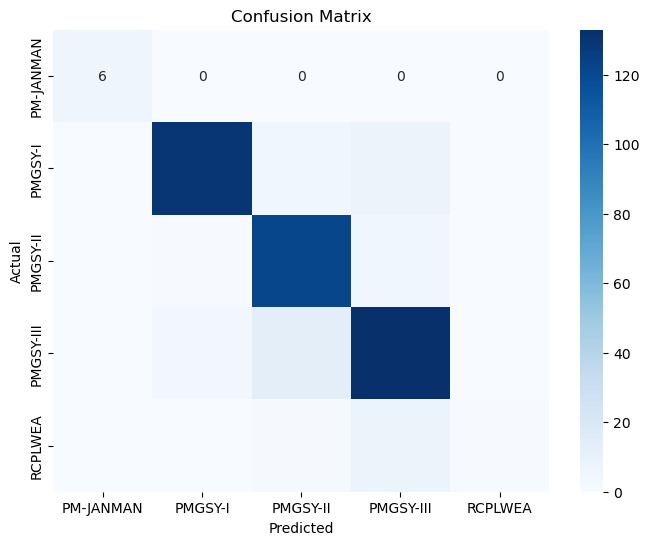


Example Prediction: PMGSY-I
Model saved as pmgsy_classifier.pkl


In [5]:
import os, types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def __iter__(self): return 0

cos_client = ibm_boto3.client(
    service_name='s3',
    ibm_api_key_id='3gcxHC-Hri6IkGFpSdvQatvKf3wLWF1gj0DuEmCSCJGJ',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.au-syd.cloud-object-storage.appdomain.cloud'
)

bucket = 'pmgsyintelligentclassification-donotdelete-pr-uirrwdols21lqt'
object_key = 'PMGSY_DATASET.csv'

body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']
if not hasattr(body, "__iter__"): 
    body.__iter__ = types.MethodType(__iter__, body)

df = pd.read_csv(body)
print("Dataset Loaded ", df.shape)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Handle missing values using SimpleImputer
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

target = 'PMGSY_SCHEME'
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

X = df.drop(target, axis=1)
y = df[target]
X = pd.get_dummies(X)

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n Model Accuracy: {acc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

sample = X_test[0].reshape(1, -1)
pred_scheme = label_encoder.inverse_transform(clf.predict(sample))
print(f"\nExample Prediction: {pred_scheme[0]}")

joblib.dump(clf, 'pmgsy_classifier.pkl')
print("Model saved as pmgsy_classifier.pkl")
